In [1]:
import gudhi
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Funções do notebook 1
def PrintSimplices(simpcomplex):
    '''
    Print a list of the simplices of the simplicial complex 'simpcomplex'.
    
    Input: 
        simpcomplex: a gudhi.SimplexTree
        
    Example:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        PrintSimplices(simpcomplex)
    '''
    simplices = {i:[] for i in range(simpcomplex.dimension()+1)}
    for filtration in simpcomplex.get_simplices():
        simplex = filtration[0]
        simplices[len(simplex)-1].append(simplex)
    print('The simplicial complex contains the following simplices: ')
    for i in range(simpcomplex.dimension()+1):
        print('Dimension '+repr(i)+': ', end="")
        print(*simplices[i], sep = ", ")
        
def DrawSimplicialComplex(simpcomplex, pos=None):
    '''
    Draw the 1-skeleton of the simplicial complex 'simpcomplex', in the plane.
    If 'pos==None', the position of the vertices are chosen at random, according to the 'spring_layout' of networkx.
    If pos is a dict 
    
    Input: 
        simpcomplex: a gudhi.SimplexTree
        pos: a dict {(vertex of simpcomplex): (list of floats of length 2) }
        
    Example 1:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        DrawSimplicialComplex(simpcomplex)

    Example 2:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        pos = {0:[0,0], 1:[0,1]}
        DrawSimplicialComplex(simpcomplex, pos=pos)
    '''
    nodes=[]; edges=[]
    for filtr in simpcomplex.get_skeleton(1):
        simplex = filtr[0]
        if len(simplex)==1:
            nodes.append(simplex[0])
        if len(simplex)==2:
            edges.append(simplex)
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    if pos == None:
        pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True, font_weight='bold', node_color='magenta')
    
def NumberOfConnectedComponents(simpcomplex, verbose = 'True'):
    '''
    Print the number of connected components of the simplicial complex 'simpcomplex'.
    
    Input: 
        simpcomplex: a gudhi.SimplexTree
        
    Example:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        NumberOfConnectedComponents(simpcomplex)
    '''    
    simpcomplex.compute_persistence()
    nbr_components = simpcomplex.betti_numbers()[0]
    if verbose: print('The simplicial complex admits '+repr(nbr_components)+' connected component(s).')
    return nbr_components

def EulerCharacteristic(simpcomplex, verbose = 'True'):
    '''
    Print the Euler characteristic of the simplicial complex 'simpcomplex'.
    
    Input: 
        simpcomplex: a gudhi.SimplexTree
        
    Example:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        EulerCharacteristic(simpcomplex)
    '''
    num_simplices = [0 for i in range(simpcomplex.dimension()+1)]
    for filtration in simpcomplex.get_simplices():
        simplex = filtration[0]
        num_simplices[len(simplex)-1]+=1
    Euler_characteristic = sum(num_simplices[::2]) - sum(num_simplices[1::2])
    if verbose: print('The simplicial complex has Euler characteristic equal to '+repr(Euler_characteristic)+'.')
    return Euler_characteristic

In [3]:
# Funções do notebook 2

def SampleOnCircle(N = 100, sd = 0):
    '''
    Sample N_observation points from the uniform distribution on the unit circle 
    in R^2, with Gaussian noise of standard deviation sd.
        
    Input: 
        N (int): number of sample points on the circle.
        N_noise (float, optional): standard deviation of the Gaussian noise
    
    Output : 
        data (np.array): size Nx2, the points concatenated.
    '''
    rand_uniform = np.random.rand(N)*2-1    
    X = np.cos(2*np.pi*rand_uniform)
    Y = np.sin(2*np.pi*rand_uniform)
    data = np.stack((X,Y)).transpose() + np.random.normal(0, sd,  (N, 2))
    return data

def BettiNumbers(st, verbose = 'True'):
    '''
    Print the Betti numbers of the simplicial complex 'st'.
    
    Input: 
        st: a gudhi.SimplexTree
        
    Example:
        st = gudhi.SimplexTree()
        st.insert([0])
        st.insert([1])
        BettiNumbers(st)
    '''    
    if st.dimension()==0:
        betti_numbers = [st.num_simplices()]
    else:
        st.compute_persistence()
        betti_numbers = st.betti_numbers()
    if verbose: 
        print('The Betti numbers are:')
        for i in range(len(betti_numbers)):
            print('Beta_'+repr(i)+' = '+repr(betti_numbers[i]))
    return betti_numbers

def PlotThickening(X,t):
    '''
    Plot a matplotlib figure representing the t-thickening of the point cloud X. 
    X must be a point cloud in the plane.
    
    Input: 
        X (np.array): size Nx2, the points concatenated.
        
    Example:
        X = np.asarray([[0,1],[1,0],[-1,1]])
        PlotThickening(X, 0.2)
    '''
    if np.shape(X)[1]!=2:
        print('Error! X is not in R^2')
        return False 
    N=np.shape(X)[0]
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot()
    for i in range(N):
        circle = plt.Circle((X[i,0], X[i,1]), t, color='magenta', alpha = 0.3)
        ax.add_artist(circle)
    for i in range(N):
        point = plt.Circle((X[i,0], X[i,1]), 0.02, facecolor='black', edgecolor = 'black', alpha = 1)
        ax.add_artist(point)
    bound = np.max(np.abs(X))+t    
    plt.xlim(-bound, bound); plt.ylim(-bound, bound)
    plt.axis('off')
    plt.show()

def GetBettiCurvesFromPointCloud(X, J, dim=3):
    '''
    Computes the Betti curves of the Rips complex on the point cloud X, 
    on the interval J, up to dimension dim.

    Input:
        X (np.array): size Nx2, the point cloud.
        J (np.array): interval. Shape 1xM. 
        dim (int, optional): maximal dimension to compute the Betti curves. 
    
    Output:
        BettiCurves (np.array): the Betti curves. Shape (dim+1)xM. The ith 
                                Betti curve is given by BettiCurve[i,:].  
                                
    Example:
        X = np.asarray([[0,1],[1,0],[-1,1]])
        J = np.linspace(0,1,100)
        GetBettiCurvesFromPointCloud(X, J, dim = 2)
    '''
    I = 2*J
    tmax = max(I)
    # na linha rips, houve uma mudança, quando X é instanciado como
    # uma matriz de pontos n x d (nuvem de pontos num espaço 2D)
    # devemos passar points = X ao instanciar RipsComplex
    # e não X diretamente
    rips = gudhi.RipsComplex(points=X, max_edge_length = tmax) 
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence(persistence_dim_max=True, homology_coeff_field = 2)
    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim+1)]
    BettiCurves = []
    step_x = I[1]-I[0]
    for diagram in Diagrams:
        bc =  np.zeros(len(I))
        if diagram.size != 0:
            diagram_int = np.clip(np.ceil((diagram[:,:2] - I[0]) / step_x), 0, len(I)).astype(int)
            for interval in diagram_int:
                bc[interval[0]:interval[1]] += 1
        BettiCurves.append(np.reshape(bc,[1,-1]))
    return np.reshape(BettiCurves, (dim+1, len(I)))

def GetBettiCurvesFromDistances(D, J, dim=2):
    '''
    Computes the Betti curves of the Rips complex of the distance matrix D, 
    on the interval J, up to dimension dim.

    Input:
        D (np.array): size NxN, the distance matrix.
        J (np.array): interval. Shape 1xM. 
        dim (int, optional): maximal dimension to compute the Betti curves. 
    
    Output:
        BettiCurves (np.array): the Betti curves. Shape (dim+1)xM. The ith 
                                Betti curve is given by BettiCurve[i,:].  

    Example:
        D = np.asarray([[0,1,2],[1,0,3],[2,3,0]])
        J = np.linspace(0,1,100)
        GetBettiCurvesFromDistances(D, J, dim = 1)
    '''
    I = 2*J
    tmax = max(I)
    rips = gudhi.RipsComplex(distance_matrix = D, max_edge_length = tmax)
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence(persistence_dim_max=True, homology_coeff_field = 2)
    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim+1)]
    BettiCurves = []
    step_x = I[1]-I[0]
    for diagram in Diagrams:
        bc =  np.zeros(len(I))
        if diagram.size != 0:
            diagram_int = np.clip(np.ceil((diagram[:,:2] - I[0]) / step_x), 0, len(I)).astype(int)
            for interval in diagram_int:
                bc[interval[0]:interval[1]] += 1
        BettiCurves.append(np.reshape(bc,[1,-1]))
    return np.reshape(BettiCurves, (dim+1, len(I)))

In [4]:
### Circle homology
N = 50
X = SampleOnCircle(N)

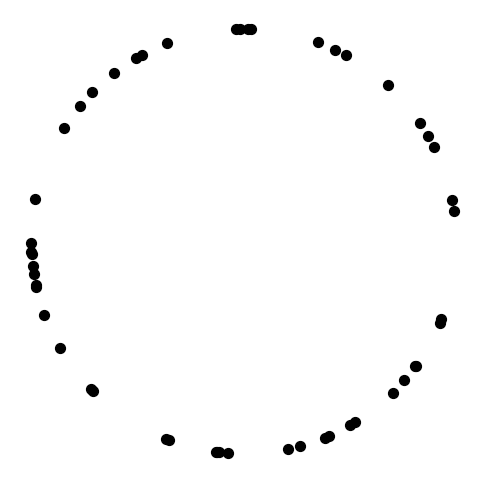

In [5]:
fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot(1, 1, 1)
plt.scatter(X[:,0],X[:,1], c='black', s=50)
plt.axis('equal'); plt.axis('off'); plt.show()

Seja $ t \geq 0 $ e o grafo $G^t$ com vértices $\{1, ..., N\}$. As arestass são os pares $(i, j)$ tal que $\lVert x_i - x_j \rVert \leq 2t$. O complexo de Rips de $X$ no tempo $t$ é o *clique complex* do grafo $G^t$

In [6]:
### Rips complex of X at time t construction
t = 0.1

# Adding the vertices / 0-simplices
st = gudhi.SimplexTree()
for i in range(N):
    st.insert([i])
    
# Adding the edges / 1-simplices
for i in range(N):
    for j in range(i):
        if np.linalg.norm(X[i, :] - X[j,:]) <= 2*t:
            st.insert([i, j])

# Computing the clique complex
st.expansion(2)

In [7]:
# Read Betti Numbers
BettiNumbers(st)

The Betti numbers are:
Beta_0 = 14
Beta_1 = 0


[14, 0]

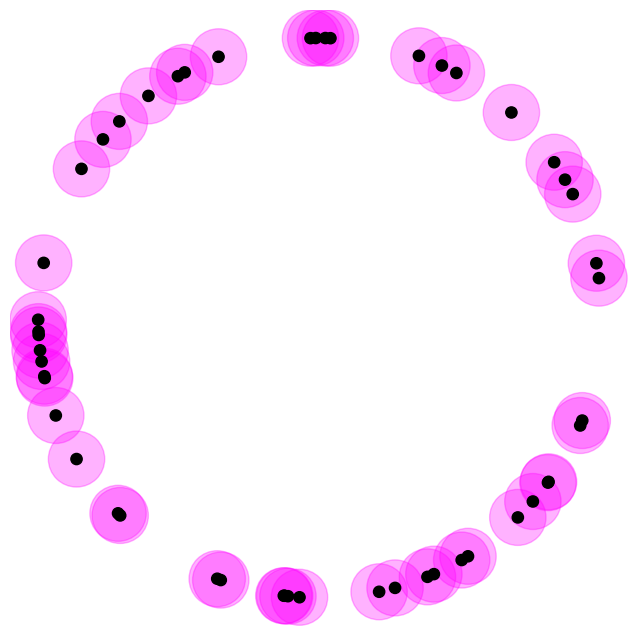

In [8]:
# Thickening of X
PlotThickening(X, t)

The Betti numbers are:
Beta_0 = 1
Beta_1 = 1


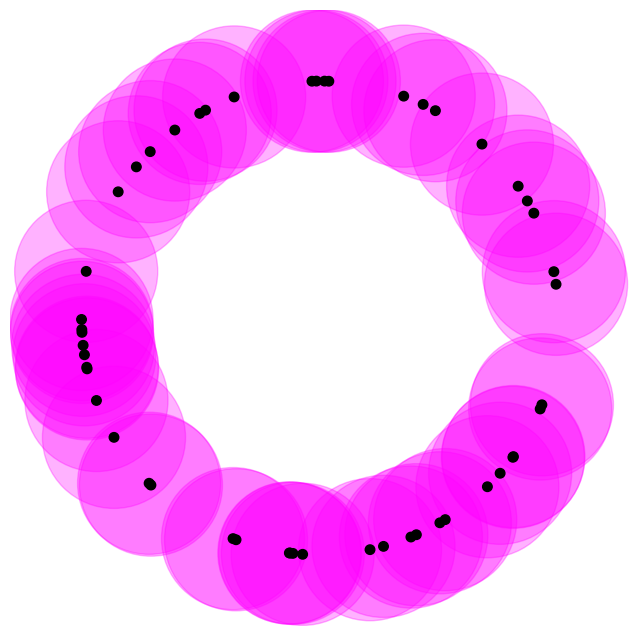

In [9]:
# For another value of t
t = 0.3

# adding the 0-simplices (vertices)
st = gudhi.SimplexTree()
for i in range(N):
    st.insert([i])
    
# adding the 1-simplices (edges)
for i in range(N):
    for j in range(i):
        if np.linalg.norm(X[i,:]-X[j,:])<=2*t:
            st.insert([i,j])

# computing the clique complex (up to the 2-simplices)           
st.expansion(2)

BettiNumbers(st)

PlotThickening(X,t)

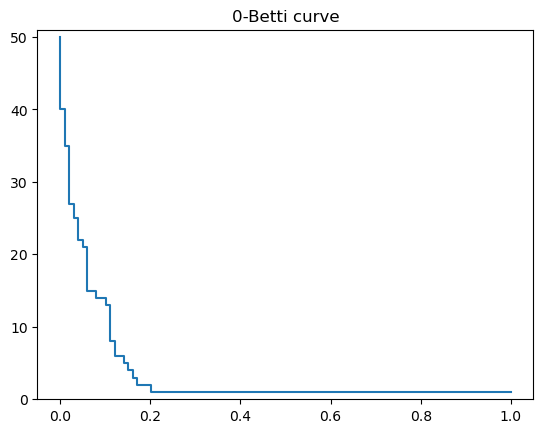

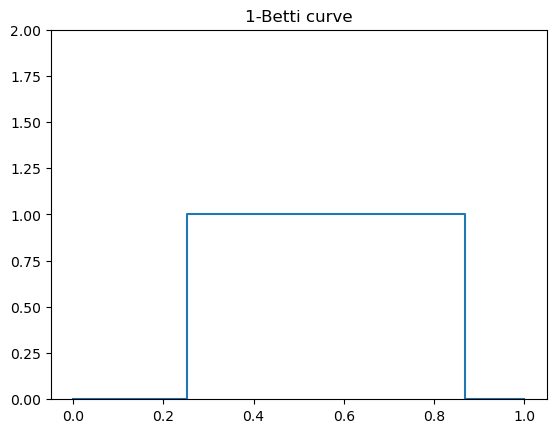

In [10]:
I = np.linspace(0,1,100)
Betti_curves = GetBettiCurvesFromPointCloud(X, I) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.title('1-Betti curve')
plt.show()

#### Homology of the noisy circle

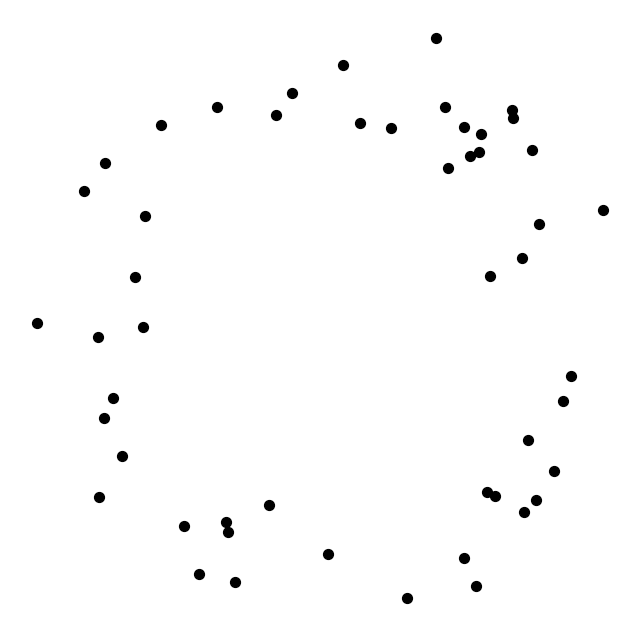

In [11]:
N = 50
sd = 0.1

X = SampleOnCircle(N, sd)
# plotting the point cloud
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(1, 1, 1)
plt.scatter(X[:,0],X[:,1], c='black', s=50)
plt.axis('equal'); plt.axis('off'); plt.show()

The Betti numbers are:
Beta_0 = 1
Beta_1 = 0


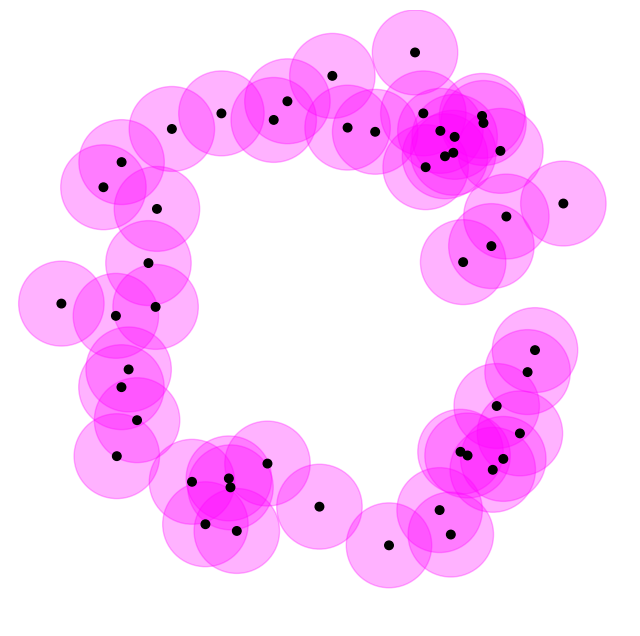

In [12]:
# Build a Rips complex at time t, 
# compute its Betti numbers and plot the thickening

t = 0.2

# adding 0-simplices (vertices)
st = gudhi.SimplexTree()
for i in range(N):
    st.insert([i])
    
# adding 1-simplices (edges)
for i in range(N):
    for j in range(i):
        if np.linalg.norm(X[i,:] - X[j,:]) <= 2*t:
            st.insert([i, j])

# compute the clique complex 
st.expansion(2)

BettiNumbers(st)

PlotThickening(X, t)

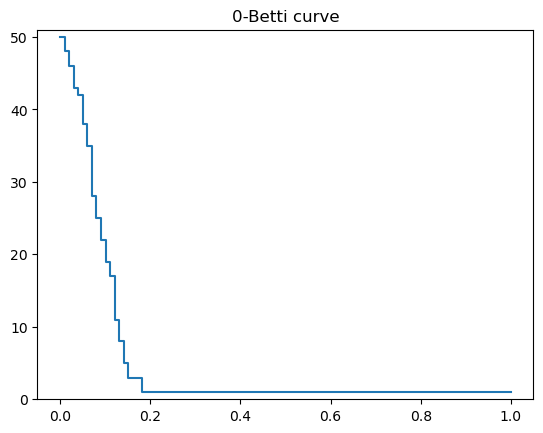

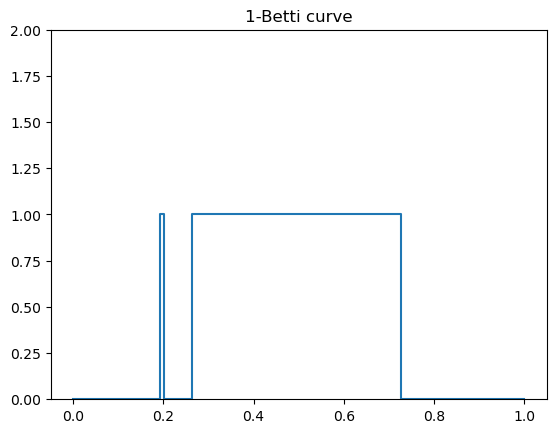

In [13]:
# Betti curves of X. 
# Observe the 1-Betti curve is less regular than in the previous example.
I = np.linspace(0,1,100)
Betti_curves = GetBettiCurvesFromPointCloud(X, I) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.title('1-Betti curve')
plt.show()

### Exercise 44
THe following is a subset of $\mathbb{R}^4$ with **200** elements. It has been sampled on a famous 2-dimensional object. **Compute the Betti curves of its Rips complex on [0, 1].** Can you recognize which surface it is?

In [14]:
data = {0: [0.5400021775006532, 0.8416636194433932, -0.6822682946709439, 0.7311018903592044],
        1: [-0.8026134821803633, 0.5964994536647218, 0.8493297809075483, -0.5278625988489202],
        2: [0.7003005937894493, 0.7138480779116413, 0.7716492089313373, -0.6360483459263465],
        3: [-0.9786166306406623, 0.205692708265309, -0.4897417926668873, 0.8718675223423703], 
        4: [0.5781950240767221, -0.8158985930450664, 0.8505465088386694, -0.5258998348567445], 
        5: [-0.8791159554953298, 0.4766079487309598, 0.9261490556218247, -0.37715769483175365], 
        6: [-0.7826176983514316, 0.6225026411406682, 0.3922940591205208, -0.9198398617035171], 7: [0.7961913290002486, 0.6050449302529672, -0.7193104891966963, 0.6946887217535704], 8: [-0.8834951174594977, 0.46844036698946895, -0.7683241450789192, -0.6400609409179315], 9: [-0.981199432932423, 0.19299656166131973, -0.9712088022254506, 0.23822985220120024], 10: [-0.5693176041915778, 0.8221176713570643, -0.9062099401921898, -0.4228280315883371], 11: [0.17133349881457016, 0.985213089734377, 0.3188508485615858, 0.9478049041715054], 12: [0.8327407852660222, 0.5536630604930481, 0.15425507167769917, 0.9880310586523624], 13: [-0.9966222631004077, 0.08212225455150195, 0.4630513921937395, -0.8863314324717586], 14: [-0.6875725679362158, 0.7261156683487817, -0.24208478136109446, 0.9702550997718853], 15: [0.9922304213281463, 0.12441378939237088, -0.8298669527155859, -0.5579613255330047], 16: [0.38433361555502354, -0.923194276387372, 0.41371480587789833, 0.9104065352343496], 17: [-0.5065965806860859, 0.8621832197608383, -0.1348431616221868, 0.9908669546229366], 18: [-0.0361567089318383, 0.9993461324282085, 0.32045398814176784, -0.9472640822305234], 19: [-0.9610742214843614, 0.27629031976931206, -0.9691289235638207, 0.24655451630832098], 20: [0.5640731614901023, 0.8257248140189085, -0.8114587054957744, 0.5844097614474986], 21: [-0.8792384106717147, 0.47638200763617966, 0.04093455010423245, -0.9991618300394407], 22: [0.7817436085356205, -0.6235999763580067, -0.36889646870272436, 0.9294704919354136], 23: [0.05858195491988199, 0.9982826025518851, -0.6547025084707521, 0.7558866485142496], 24: [0.6463602117886624, 0.7630324217335168, 0.4139661068912301, -0.9102922950049169], 25: [-0.33501710924416556, -0.9422120443475995, 0.7287356882518164, -0.6847950764047237], 26: [-0.7137374846960013, 0.7004133086541298, 0.5160526297762157, -0.8565568768628573], 27: [-0.9713664876757305, 0.23758608254802077, -0.16088288301164633, -0.9869735041802596], 28: [0.2202582242183198, 0.9754415998224559, -0.9750708174808401, 0.22189389558355638], 29: [0.743849817094733, -0.6683468033948635, 0.6022027455931742, -0.7983431926183392], 30: [-0.9674998557575348, 0.25287156643076586, -0.052356271448902314, -0.9986284698725392], 31: [-0.9965285195060417, 0.08325208592640032, -0.21182989645548017, -0.9773065511740217], 32: [-0.7748522156293235, -0.6321424237735737, -0.8567944258037608, 0.5156581347284303], 33: [0.5417562980726583, -0.8405356110829624, -0.9984997438877148, -0.05475638278929576], 34: [-0.9535261153849635, -0.3013103836227046, -0.7133941010795583, 0.7007630530677892], 35: [0.9100878489136783, -0.4144153800954712, 0.8954131089897818, -0.4452363015851844], 36: [0.4630310321282753, 0.886342069003962, -0.594643945637773, -0.8039891652978548], 37: [0.9443937279975954, 0.3288167978051058, 0.5055436893655878, -0.8628010072679737], 38: [0.3837266131167077, -0.9234467425823649, -0.22488441917661614, 0.9743854463258347], 39: [-0.06691301994026976, -0.9977588124203529, -0.886726908109613, 0.4622936192879651], 40: [-0.8374554544295875, 0.5465055917793825, -0.3985894054887749, -0.9171294814976264], 41: [-0.35094143430080094, 0.9363974101261155, 0.3983846514744652, -0.9172184415228298], 42: [-0.999985323459167, -0.005417828556257727, -0.010717933385150173, -0.9999425613023738], 43: [0.04755072620004681, -0.9988688244398501, 0.9357806308885601, -0.35258277163498564], 44: [0.8564484746445715, -0.5162325157126262, -0.9767055931253954, -0.2145837467227414], 45: [-0.41556011207261817, -0.9095657168419404, 0.66072566065051, 0.7506274717580933], 46: [-0.8157283776232888, -0.578435142379919, -0.2638715302833815, 0.9645578341944595], 47: [0.32836074390497716, 0.9445523923330934, 0.9670529035014827, -0.2545754933793749], 48: [0.7910825945356164, 0.6117093497918743, 0.9160986217446592, 0.4009530087647878], 49: [0.6856780539511739, -0.7279049431963841, 0.6802885692367758, 0.7329443789031883], 50: [-0.9730889467238255, 0.2304298196065689, -0.9831546849574074, 0.18277545088523509], 51: [0.964626748290962, 0.263619491846876, 0.5577408699263698, 0.8300151336052712], 52: [-0.37790381976087956, 0.9258448590396431, 0.5682352233999919, 0.8228661682725578], 53: [-0.38504851734033774, -0.9228963318238986, 0.9690039901463502, -0.24704507094951722], 54: [-0.658311155247941, 0.7527459218595085, 0.9680668962776582, 0.2506920109044998], 55: [-0.995685033540969, 0.09279716581081154, -0.9968644386789001, 0.07912831918726368], 56: [0.9942988078572735, 0.10662964265908711, 0.9969032939807477, 0.07863728409816156], 57: [0.21143023937285824, 0.9773930907668296, 0.9421383999122718, -0.33522415696179225], 58: [-0.7544287444428185, 0.6563819540164344, -0.46143927831732995, -0.8871717942010903], 59: [-0.9344650491469317, -0.35605487206724534, 0.9884222620789475, 0.15172815106873347], 60: [-0.244872045027763, 0.9695554040713307, 0.5653288259365284, -0.8248656366737714], 61: [-0.5766131218739391, -0.8170173239796019, -0.9973023218528374, 0.07340353415837335], 62: [-0.999861623118875, 0.016635342319553645, 0.8677793348687388, -0.4969497217775348], 63: [-0.4582119285533071, 0.8888429718074273, 0.8797782576498177, -0.47538428388688986], 64: [-0.360429772537355, 0.9327863523169014, -0.08085013695863692, 0.9967262690196189], 65: [-0.8140639874504145, -0.5807751925972142, -0.3653595174940193, -0.9308664904144619], 66: [-0.9594467985932399, 0.28188976687560496, -0.43797632460824604, 0.8989865066187881], 67: [0.8920527673047695, -0.4519312562148172, 0.1824919746003026, 0.9832073429376341], 68: [-0.6707634656700608, -0.7416713376707293, 0.3747570131963199, -0.9271230668364224], 69: [-0.9144254347190597, 0.404754400024087, 0.8193995397507423, -0.5732228137960593], 70: [-0.8718173414873371, -0.48983111689841824, -0.8794249546708074, 0.47603755009688925], 71: [-0.5777309149726426, 0.8162272905783493, 0.9794726541336494, -0.2015770815454587], 72: [0.994196362203701, 0.10758063664492522, -0.3814344263724101, -0.9243958991568225], 73: [0.44736248965252345, 0.8943527284309563, -0.7744296290333358, -0.6326600585427294], 74: [-0.5348633853990291, 0.8449385533631956, 0.32122233059877947, 0.9470038090338858], 75: [0.0818903217739068, 0.9966413473259906, 0.7643834514617666, 0.6447619243809277], 76: [0.6644681293736355, -0.7473166029513204, 0.6522799128837073, -0.7579781759710652], 77: [-0.6497166757921392, -0.7601764539878964, -0.3221442375611435, -0.9466905989847737], 78: [0.9941576678036071, -0.10793762804181309, 0.9954716172423985, 0.09505924081752162], 79: [-0.5207763956143086, 0.8536931215436664, -0.6604603388694422, 0.7508609330498301], 80: [-0.9968812402222557, -0.07891636644535444, 0.755938753460183, 0.6546423458783159], 81: [0.6080992869799383, -0.7938609810127278, -0.9751513937047076, 0.2215395209793645], 82: [0.9682868404436831, 0.24984113877340028, -0.7300761262723476, 0.683365824318983], 83: [0.9360615123361801, -0.3518363897082043, 0.8756249415632074, 0.4829916787196543], 84: [-0.3587198404209049, -0.9334452721442219, 0.15415861056647973, 0.9880461136952123], 85: [-0.07428806587451739, 0.9972368240636842, -0.9964007774949645, 0.08476727320983149], 86: [0.8749473754251763, -0.48421801932249026, 0.9510481348469547, -0.3090427886298733], 87: [0.9901461223134077, 0.14003805364158045, -0.9980524096043363, -0.062380988153268466], 88: [-0.3041090713948789, 0.9526372198771914, 0.9042248216335874, -0.4270567549421354], 89: [0.9983458215415766, -0.057494526787117105, -0.25394251272732776, -0.9672193134081489], 90: [-0.9504703340868105, 0.31081528923286084, 0.05721624246989065, 0.9983618089638779], 91: [0.9726910639340923, 0.23210362802585305, -0.700602900929682, -0.7135513823186905], 92: [0.7013886628943727, -0.712779028565827, 0.6630289406864811, 0.748593764208708], 93: [-0.964220436020806, -0.2651017743430752, -0.9999724445748382, 0.007423617111758388], 94: [-0.929873755605958, 0.36787878252934225, -0.952818563934601, -0.3035404161254391], 95: [-0.7647088819279465, -0.6443759197087597, -0.44289309241731395, 0.8965744300887845], 96: [0.23527742128976792, 0.9719282561131953, 0.6717389715383073, 0.7407879278961402], 97: [0.9473433390229902, -0.32021960903225755, 0.9001403186375336, 0.43560005367667193], 98: [0.6982230118449742, -0.7158803152274359, -0.9820028513343994, -0.18886609005088664], 99: [0.2780141563214674, -0.9605769770741243, 0.012189107043060267, -0.99992571007525], 100: [-0.3192202730518915, 0.9476805460030695, 0.9993850690946289, -0.03506399393571599], 101: [-0.9694342617584609, 0.24535120160461374, 0.5486854510913934, -0.8360288725640007], 102: [-0.7128032634738665, 0.7013640335667389, 0.7649286934834325, -0.6441149694625401], 103: [0.9988658398372691, -0.04761338053727205, -0.896904922143035, 0.44222342841101975], 104: [-0.08380063037403025, 0.9964825409152511, -0.862740681306464, -0.5056466323618288], 105: [0.5985808478130907, -0.8010623999610527, -0.4661719532740725, -0.8846941335742178], 106: [-0.3768862143069771, 0.9262595648441938, -0.7987408457923934, -0.6016752124384485], 107: [-0.31536337422007366, 0.948970991232361, -0.9091694359206924, -0.41642638819802225], 108: [0.9997555050649005, -0.022111763666106024, -0.6694798739360105, 0.7428301948592447], 109: [0.7045740476154122, -0.7096304752664128, 0.9340617985551146, -0.3571114062585854], 110: [0.29713287954760614, -0.9548361387650489, 0.3412714823947635, 0.9399647734378563], 111: [-0.5229439967523026, -0.8523670431573054, -0.05433152422988931, 0.9985229519018864], 112: [-0.3468971606634786, -0.9379031719338712, -0.8392821209089159, -0.5436961665513487], 113: [0.8932647072915808, 0.4495310475454242, 0.9857429706091668, 0.16825812281912345], 114: [-0.9925094855829784, 0.12216759401662823, 0.7551107655064597, 0.655597232922965], 115: [-0.937928854252422, 0.34682771567557696, -0.7293863293339368, -0.6841020264410609], 116: [0.5891508579674152, -0.8080230606587034, 0.23941083879175246, -0.9709183540695013], 117: [0.9955620389396931, -0.09410752691597545, -0.997597869625765, 0.06927113769915362], 118: [-0.6032550798753716, 0.7975483111414374, -0.684351038455518, -0.7291526974268518], 119: [0.9961103077427417, -0.08811500898632726, 0.9135454695351561, 0.4067366163646828], 120: [-0.7434799839419928, -0.6687581875966934, -0.5051262498238486, -0.8630454633093757], 121: [-0.988227541409148, 0.152991262497015, 0.7833547509327923, -0.6215748822073033], 122: [-0.8138427210139121, 0.5810852135897726, 0.9098697937868575, -0.414893912168233], 123: [0.11082130941970636, 0.993840348033074, -0.9644908868054028, -0.26411612837789294], 124: [0.6905875887256532, -0.7232487693028506, -0.5894945200710029, 0.807772375614726], 125: [-0.8943834662992748, -0.44730103421576606, -0.6659361143357748, 0.7460087744948916], 126: [0.40009230640345284, -0.9164748476400024, -0.03879618176341638, 0.9992471447447723], 127: [0.7215238439084081, -0.6923895887949465, 0.3712763340068234, -0.9285224196574112], 128: [0.6010091993977396, 0.7992421048964375, 0.3273610698996377, -0.9448993226339855], 129: [0.46907513625670755, 0.883158262456821, 0.1314758357831827, -0.9913193756832929], 130: [-0.7039351263200976, -0.710264273304457, -0.04224621595728018, -0.9991072300995979], 131: [0.03582592279353314, -0.9993580455752542, -0.009930103841114805, -0.9999506953033758], 132: [-0.5642083036666816, 0.825632478814615, -0.5452145628860876, -0.8382965348949811], 133: [-0.5612635649013784, -0.8276371250217067, -0.9075459297516433, 0.41995283710343634], 134: [0.8995542345516663, 0.43680908770327326, -0.9315445875222834, 0.3636271187053281], 135: [0.9829346128342233, 0.18395528503534617, 0.558422686567807, -0.8295565701785459], 136: [0.9535304959673295, -0.30129652049152267, 0.5737070696387799, -0.8190605583511418], 137: [0.9790248715195744, 0.2037407689837279, 0.992362135519995, -0.12335879371246786], 138: [0.3351068877887988, 0.9421801174703833, -0.39010178724135214, -0.9207717391357658], 139: [0.46623402961266697, -0.8846614209013157, -0.8439737783109, -0.5363844344531483], 140: [0.9635282186572051, 0.26760674851593946, 0.1422881244807212, -0.9898252823765207], 141: [-0.7814394249756893, -0.623981109564756, 0.06503365153954431, -0.9978830713903474], 142: [-0.9187780036735574, 0.39477459387051805, -0.8755489475582384, 0.4831294240984097], 143: [-0.6804102160995571, -0.7328314525369076, -0.6887636382471543, 0.7249859658148862], 144: [-0.994846454215113, 0.10139296097667261, -0.26777882206674947, 0.9634804110372687], 145: [-0.62231681276853, -0.7827654722492673, -0.9998843962088352, -0.015205072117328106], 146: [-0.898124111758587, -0.43974206061946036, 0.9349464420458026, -0.35478888159847227], 147: [0.1525763223469046, -0.9882916906759327, 0.6328820560007269, -0.7742482180749871], 148: [0.5139010878212042, 0.8578494459613429, -0.8344580915809221, -0.5510714049877071], 149: [0.7922257274701958, -0.6102281513780884, -0.5627605280272245, 0.8266199780398], 150: [0.8744485496024509, -0.48511826815547776, 0.6751998168195913, -0.7376348740174846], 151: [-0.7979518380491928, -0.6027212159480656, -0.6530955120871503, 0.7572755456844112], 152: [0.9769475786191761, -0.21347934005455596, -0.2234702933632543, 0.9747107406734272], 153: [-0.7819244350575288, 0.6233732251708958, 0.3243747712748298, -0.9459286483453189], 154: [0.5655571218625955, 0.8247091256379411, -0.7347050561635936, -0.6783866747273642], 155: [-0.9801960682986571, 0.1980294616764241, -0.9574218725612147, 0.2886924972031265], 156: [-0.437314329854761, -0.8993087216877647, 0.5664669406308963, 0.8240844648288624], 157: [-0.3202787321198973, -0.9473233522676779, -0.868559453744315, -0.4955849829356991], 158: [0.01103437898217967, 0.9999391193870143, 0.13581239696328545, -0.9907345723406885], 159: [0.7060777112870961, -0.708134355630043, 0.89883649274261, -0.43828410798723233], 160: [-0.1074810976197676, -0.9942071281450611, 0.25820849006092844, 0.966089217236408], 161: [0.6956663212514669, 0.7183650669934131, -0.707275330363608, -0.7069381918237614], 162: [0.9649301308697548, -0.2625068428435302, -0.2985171138237701, -0.954404281609385], 163: [-0.5788221039842223, 0.8154538441501629, 0.7587051083134657, 0.6514342319981752], 164: [-0.3932029833904468, 0.9194516919625805, -0.019570077035758127, 0.9998084877039275], 165: [0.6161941940179063, -0.7875942580152695, -0.44705748431510617, -0.8945052295642819], 166: [0.21450309226407058, 0.9767233095453142, 0.5351652971217873, 0.8447473614972403], 167: [-0.8033805471846226, 0.5954659489889714, 0.964023676829886, 0.2658163849565853], 168: [-0.3979892629841222, 0.9173900732781859, 0.4419667332577926, 0.8970314413070677], 169: [-0.10120976164649752, -0.994865108518466, -0.9551870187015457, -0.2960029717824687], 170: [-0.7263894067644691, 0.6872833693174619, 0.810294551082433, 0.5860228156702761], 171: [0.9578881190747057, -0.2871416920886313, 0.6432778213367154, 0.765632839274994], 172: [0.06192510407279702, 0.9980807990766947, 0.9078099240795017, 0.4193818567162502], 173: [-0.8413834204707132, 0.5404386549433736, -0.01820365031134937, 0.9998342998293978], 174: [0.5280594105597606, 0.8492074298540246, -0.877467818142277, -0.47963551591248094], 175: [-0.614633806020868, 0.7888125788147029, 0.9999951714971745, -0.003107568557007443], 176: [-0.15249597568888076, -0.9883040915622561, -0.9014654894421261, 0.43285098052894383], 177: [-0.1052047148063776, 0.9944505859933458, -0.7629334279169109, 0.6464770564892088], 178: [-0.9965415490812463, -0.08309597435947187, 0.9559700283851309, -0.2934643161090154], 179: [0.8982013848444748, -0.43958420383752167, -0.9388693174062326, 0.3442737353228603], 180: [-0.7404910538825619, 0.6720662163209015, -0.4100106157759109, 0.9120807502359966], 181: [0.9908177622163056, 0.13520414962815477, 0.808192442784989, -0.5889184794394147], 182: [0.30254737541538096, 0.9531343481531156, 0.1658344256334374, -0.9861536103847249], 183: [0.8303825405406406, -0.5571937152959204, -0.7689543124552884, -0.6393037348212621], 184: [0.36172077174026623, -0.9322864813412378, -0.933054764560394, -0.35973435522778135], 185: [-0.7873803134759683, 0.6164675514173361, 0.9894374992109437, -0.14496011573944684], 186: [0.023719756135542835, 0.9997186470046812, -0.9871290773427026, 0.15992555975998546], 187: [0.39047707196472153, -0.9206126526774753, -0.5078965394642982, -0.8614180780551279], 188: [0.9153522745596832, 0.40265396242731116, -0.46988929044746236, 0.8827253563384142], 189: [-0.9337344394406183, -0.357966474132026, 0.908498600084233, 0.4178878960259424], 190: [0.3479336083912797, -0.9375191753515357, 0.4772374489826721, -0.878774383609645], 191: [0.5621450033127129, 0.8270386902984346, -0.8792040448041527, 0.4764454298238335], 192: [-0.17451561581266667, -0.984654406295694, -0.9755538309675744, -0.21976060357691346], 193: [0.9645006419703611, 0.2640805021934814, 0.8611458881146055, 0.5083579048104861], 194: [0.8295943045886103, -0.5583666266837052, 0.9325710815369744, 0.3609863957006661], 195: [-0.6190863762900065, -0.7853229009089882, 0.42787412611765785, -0.9038383329993538], 196: [0.050765260797949005, -0.9987106128884965, -0.9312053495641041, -0.36449498891369503], 197: [0.2671785084379736, 0.9636470539719715, -0.11822660402663424, -0.9929866414510969], 198: [0.4217166802977216, -0.906727655671023, -0.9894993643513214, -0.14453721994120036], 199: [-0.997410490054251, 0.07191880372850229, 0.7337491537513641, -0.6794204731748648]}


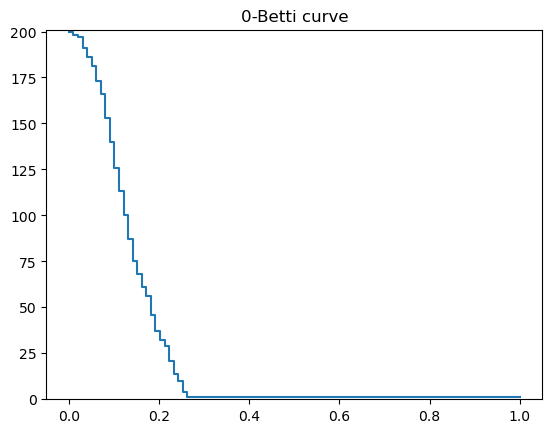

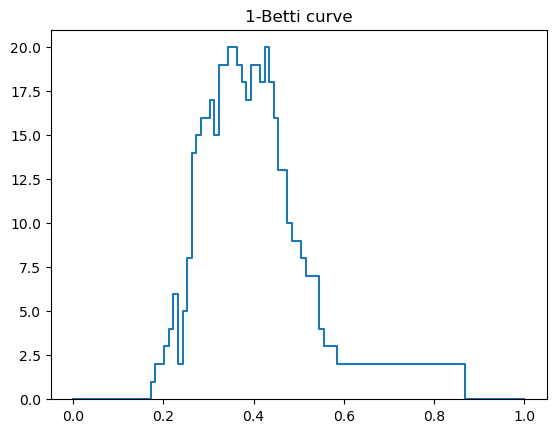

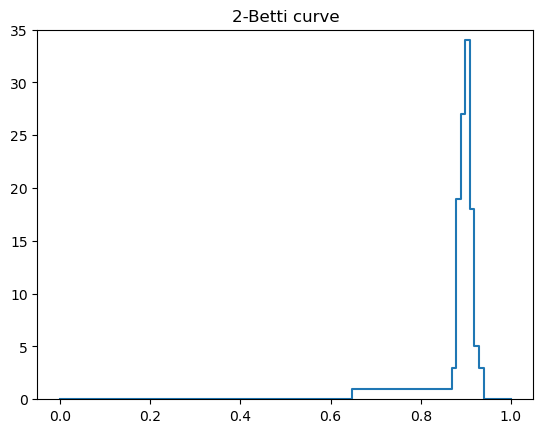

In [15]:
X = np.array(list(data.values())) 

I = np.linspace(0, 1, 100)
Betti_curves = GetBettiCurvesFromPointCloud(X, I, dim = 3) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
#plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[2])
plt.ylim(0, max(Betti_curves[2])+1)
#plt.ylim(0, 5)
plt.title('2-Betti curve')
plt.show()


#### Exercise 45
In the notebook is given a collection of images from https://www.cs.columbia.edu/CAVE/software/softlib/coil-20.php. It consists of 20 objects, for each of which 72 pictures have been taken. Each image has 128×128 pixels. Embed each collection of 72 images in $\mathbb{R}^{128 \times 128}$, and compute the Betti curves of the corresponding Rips complex.

In [31]:
# Para i = 2, temos
file2 = r"C:\Users\jmlnn\Downloads\Exercise45\cloud2.txt"
matrix = open(file2).read()
matrix = np.asarray([[float(a) for a in item.split()] for item in matrix.split('\n')[:-1]])
matrix.shape

(72, 16384)

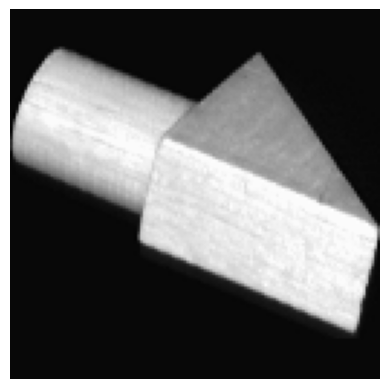

In [33]:
image = np.reshape(matrix[2], (128,128))
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.axis('off'); plt.show()

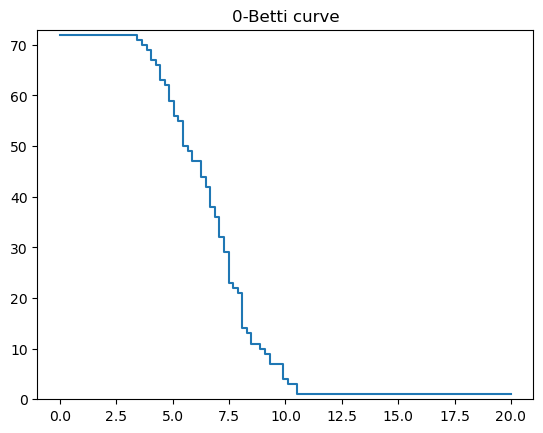

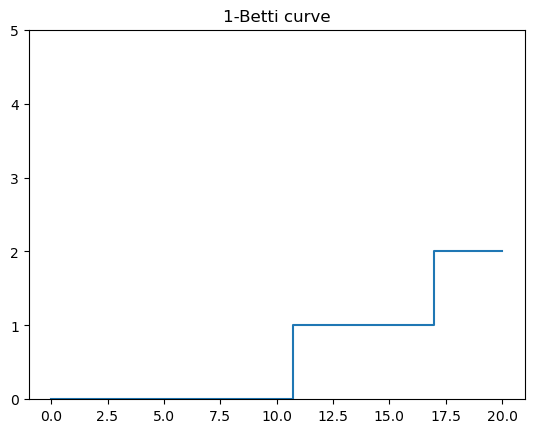

In [39]:
I = np.linspace(0,20,100)
X = matrix

Betti_curves = GetBettiCurvesFromPointCloud(X, I, dim = 2) 
plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

Guess the topology for $i = 1, 4, 7, 10, 13$ e $20$.

In [54]:
file1 = r"C:\Users\jmlnn\Downloads\Exercise45\cloud1.txt"
matrix = open(file1).read()
matrix = np.asarray([[float(a) for a in item.split()] for item in matrix.split('\n')[:-1]]) 

(72, 16384)

In [55]:
file4 = r"C:\Users\jmlnn\Downloads\Exercise45\cloud4.txt"
matrix4 = open(file4).read()
matrix4 = np.asarray([[float(a) for a in item.split()] for item in matrix4.split('\n')[:-1]])

In [57]:
file7 = r"C:\Users\jmlnn\Downloads\Exercise45\cloud7.txt"
matrix7 = open(file7).read()
matrix7 = np.asarray([[float(a) for a in item.split()] for item in matrix7.split('\n')[:-1]])

In [60]:
file10 = r"C:\Users\jmlnn\Downloads\Exercise45\cloud10.txt"
matrix10 = open(file10).read()
matrix10 = np.asarray([[float(a) for a in item.split()] for item in matrix10.split('\n')[:-1]])

In [61]:
file13 = r"C:\Users\jmlnn\Downloads\Exercise45\cloud13.txt"
matrix13 = open(file13).read()
matrix13 = np.asarray([[float(a) for a in item.split()] for item in matrix13.split('\n')[:-1]])

In [62]:
file20 = r"C:\Users\jmlnn\Downloads\Exercise45\cloud20.txt"
matrix20 = open(file20).read()
matrix20 = np.asarray([[float(a) for a in item.split()] for item in matrix20.split('\n')[:-1]])

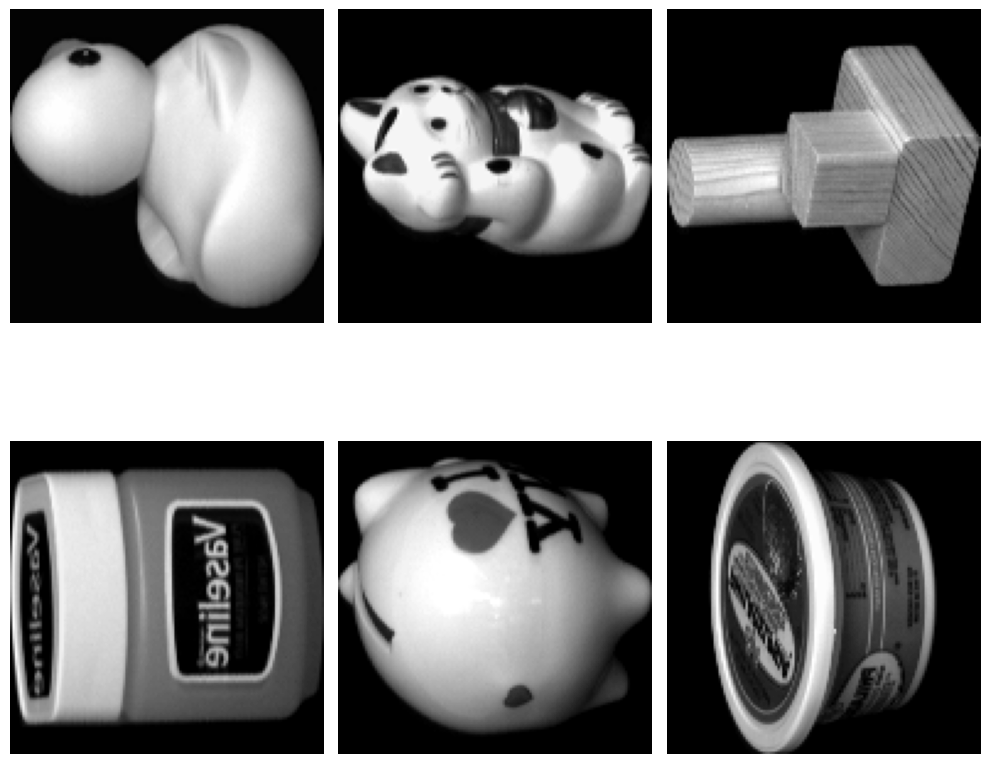

In [65]:
image1 = np.reshape(matrix[2], (128, 128))
image4 = np.reshape(matrix4[1], (128, 128))
image7 = np.reshape(matrix7[2], (128, 128))
image10 = np.reshape(matrix10[0], (128, 128))
image13 = np.reshape(matrix13[1], (128, 128))
image20 = np.reshape(matrix20[2], (128, 128))

# Grid de 3 linhas por 3 colunas
fig, axes = plt.subplots(2, 3, figsize=(10, 10))  

images = [image1, image4, image7, image10, image13, image20]  

for ax, img in zip(axes.ravel(), images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


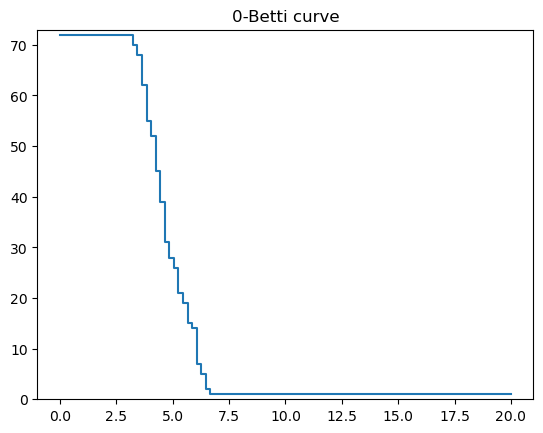

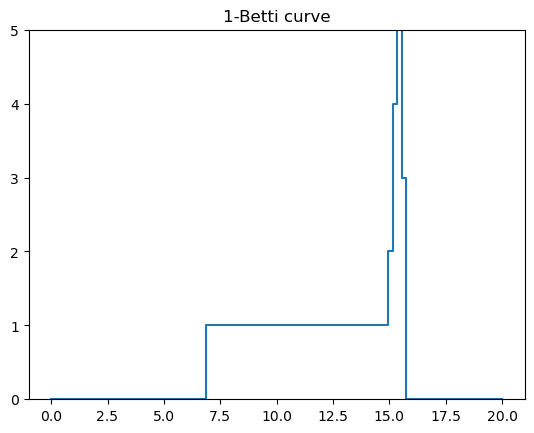

In [66]:
I = np.linspace(0,20,100)
Betti_curves = GetBettiCurvesFromPointCloud(matrix, I, dim = 2) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

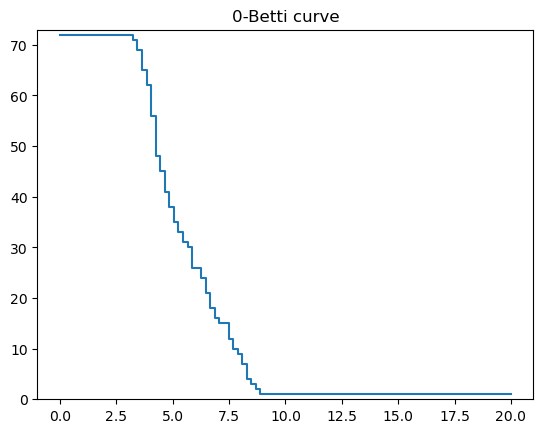

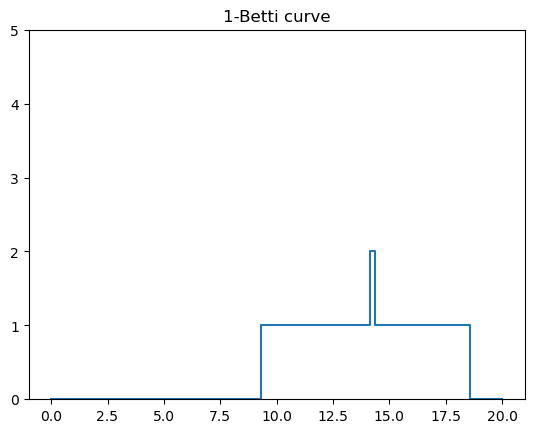

In [67]:
I = np.linspace(0,20,100)
Betti_curves = GetBettiCurvesFromPointCloud(matrix4, I, dim = 2) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

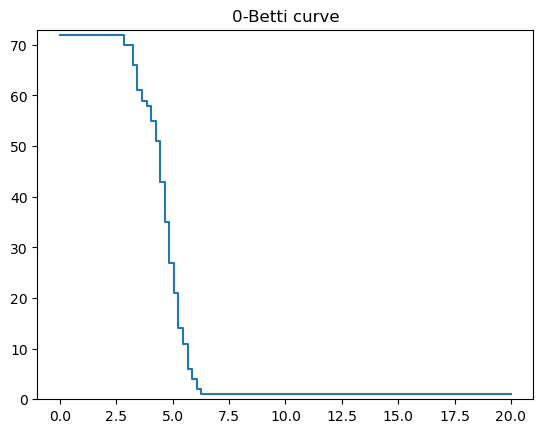

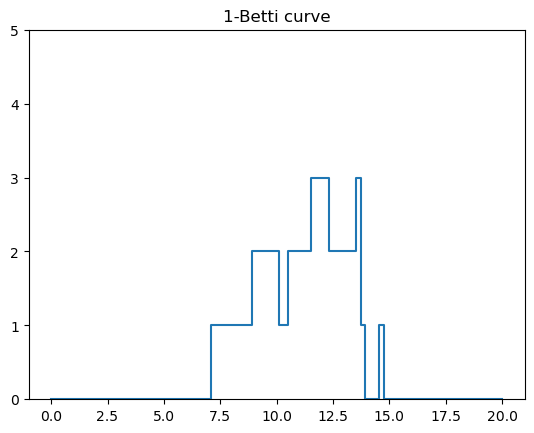

In [68]:
I = np.linspace(0,20,100)
Betti_curves = GetBettiCurvesFromPointCloud(matrix7, I, dim = 2) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

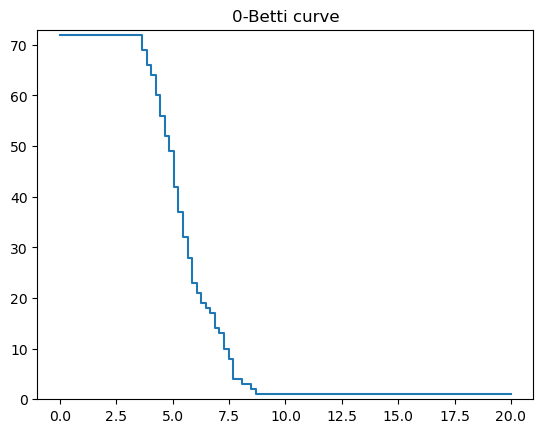

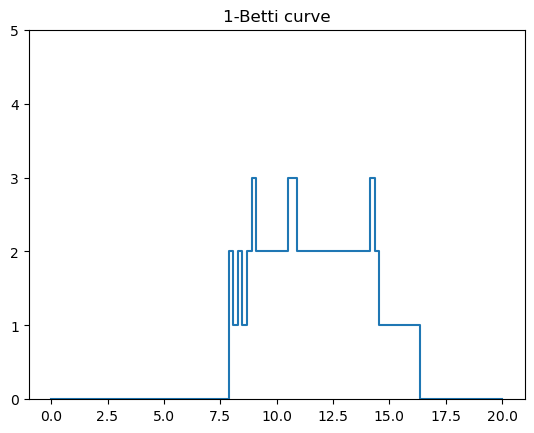

In [69]:
I = np.linspace(0,20,100)
Betti_curves = GetBettiCurvesFromPointCloud(matrix10, I, dim = 2) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

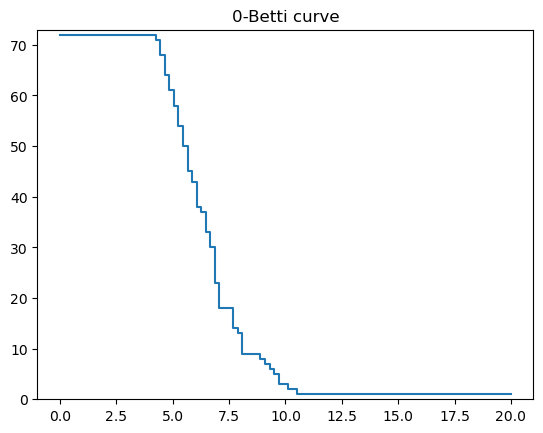

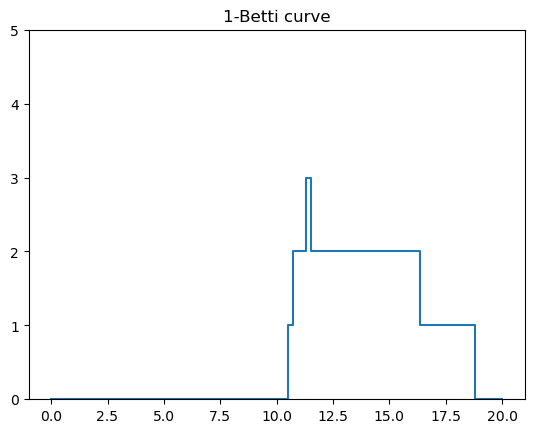

In [70]:
I = np.linspace(0,20,100)
Betti_curves = GetBettiCurvesFromPointCloud(matrix13, I, dim = 2) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

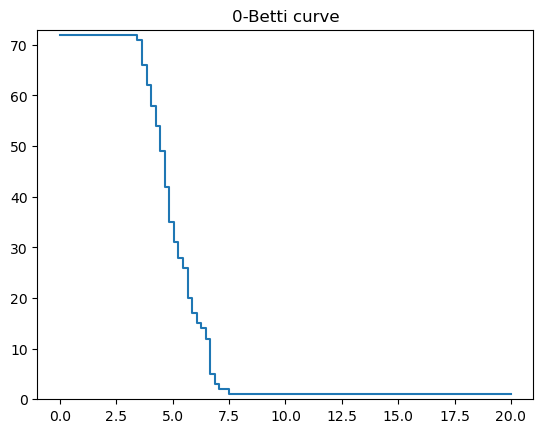

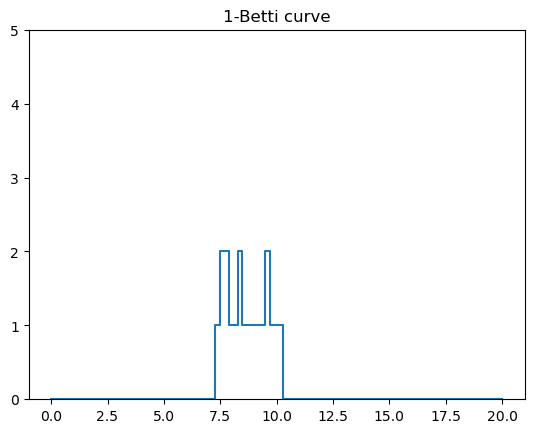

In [71]:
I = np.linspace(0,20,100)
Betti_curves = GetBettiCurvesFromPointCloud(matrix20, I, dim = 2) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

 - i = 1, 4 e 20: círculo
 - i = 7, 10 e 13: um buquê de dois círculos

####  Exercise 46
We are given the data of [KNBNH16], where the authors study the maltose-binding protein (MBP). Such a protein can be grouped into 370 components, called amino acid residues. There is two types of MBPs: open and closed. The goal is to identify these types from topological properties of the proteins.

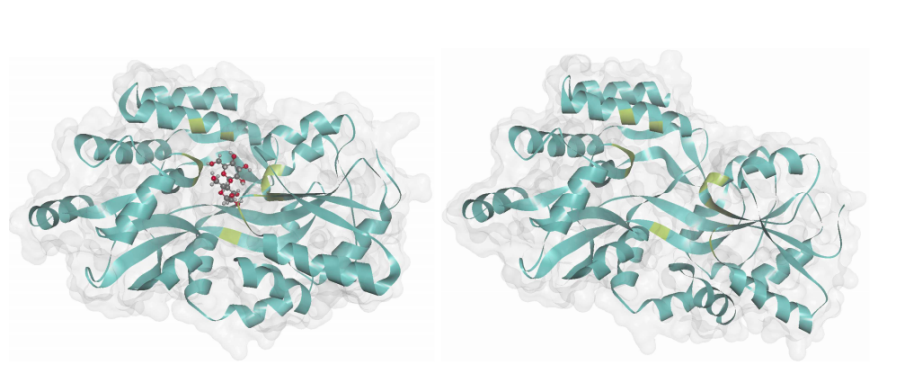

The daset consists in 14 correlation matrices, each matrix representing correlations between the 370 components of a protein. Transform the matrices of correlations into matrices of distances, via the formula $D_{ij} = 1−|C_{ij} |.$ Then, compute the 1-Betti curves of the Rips complex for each of these matrices of distances. Compare the Betti curves
of the different proteins. Do you recognize two different types of proteins (open and closed)?


In [32]:
file = r"C:\Users\jmlnn\OneDrive\Engenharia\1. Matemática\Topological Data Analysis\0_mbp_closed\3mbp.corr_6.txt"
corr = open(file).read()
corr = np.asarray([[float(a) for a in item.split()] for item in corr.split('\n')[:-1]])

In [33]:
corr.shape

(370, 370)

In [35]:
corr

array([[ 1.        ,  0.50409479,  0.38439364, ..., -0.16149546,
        -0.12390036, -0.1085305 ],
       [ 0.50409479,  1.        ,  0.9238092 , ..., -0.39710776,
        -0.30160767, -0.28409471],
       [ 0.38439364,  0.9238092 ,  1.        , ..., -0.27821385,
        -0.19676345, -0.18555187],
       ...,
       [-0.16149546, -0.39710776, -0.27821385, ...,  1.        ,
         0.95485855,  0.93747516],
       [-0.12390036, -0.30160767, -0.19676345, ...,  0.95485855,
         1.        ,  0.96472146],
       [-0.1085305 , -0.28409471, -0.18555187, ...,  0.93747516,
         0.96472146,  1.        ]])

In [46]:
# Load the correlation matrices of some points
# Convert them into distance matrices
# Compute their Betti Curves 
# Compute the 1-Betti curves of several MBP.

# Aplicando a fórmula Dij = 1 - |Cij|
D = 1 - np.abs(corr)

I = np.linspace(0, 0.2, 100)

Betti_curves = GetBettiCurvesFromDistances(D, I, dim = 2)

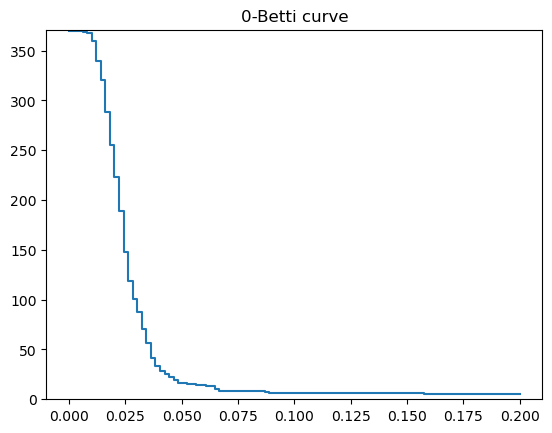

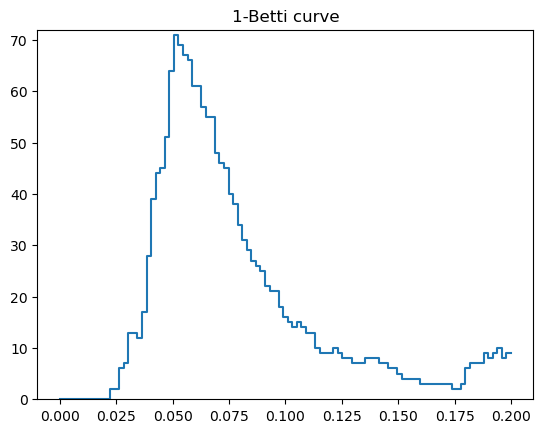

In [47]:
plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.title('1-Betti curve')
plt.show()

In [57]:
# Proteínas 1 e 2 do dataset Closed
file1 = r"C:\Users\jmlnn\OneDrive\Engenharia\1. Matemática\Topological Data Analysis\0_mbp_closed\1anf.corr_1.txt"
corr1 = open(file1).read()
corr1 = np.asarray([[float(a) for a in item.split()] for item in corr1.split('\n')[:-1]])

D1 = 1 - np.abs(corr1)

file2 = r"C:\Users\jmlnn\OneDrive\Engenharia\1. Matemática\Topological Data Analysis\0_mbp_closed\1fqc.corr_2.txt"
corr2 = open(file2).read()
corr2 = np.asarray([[float(a) for a in item.split()] for item in corr2.split('\n')[:-1]])

D2 = 1- np.abs(corr2)

BettiClosed1 = GetBettiCurvesFromDistances(D1, I, dim = 2) 
BettiClosed2 = GetBettiCurvesFromDistances(D2, I, dim = 2)

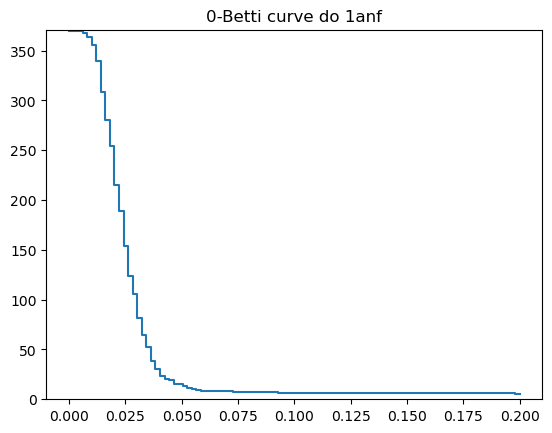

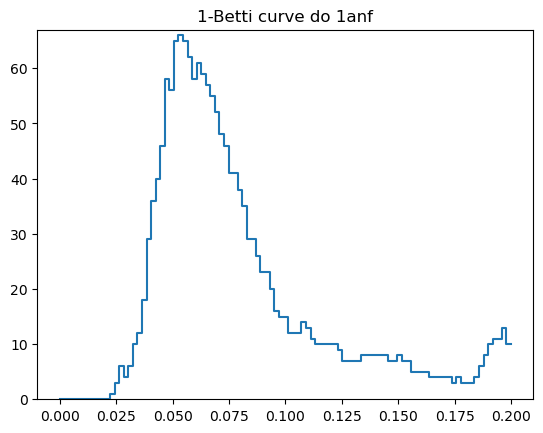

In [62]:
plt.figure()
plt.step(I, BettiClosed1[0])
plt.ylim(0, max(BettiClosed1[0])+1)
plt.title('0-Betti curve do 1anf')
plt.show()

plt.figure()
plt.step(I, BettiClosed1[1])
plt.ylim(0, max(BettiClosed1[1])+1)
plt.title('1-Betti curve do 1anf')
plt.show()

In [69]:
file3 = r"C:\Users\jmlnn\OneDrive\Engenharia\1. Matemática\Topological Data Analysis\0_mbp_open\1ez9.corr_1.txt"
corr3 = open(file3).read()
corr3 = np.asarray([[float(a) for a in item.split()] for item in corr3.split('\n')[:-1]])

D3 = 1 - np.abs(corr3)

file4 = r"C:\Users\jmlnn\OneDrive\Engenharia\1. Matemática\Topological Data Analysis\0_mbp_open\1fqa.corr_2.txt"
corr4 = open(file).read()
corr4 = np.asarray([[float(a) for a in item.split()] for item in corr4.split('\n')[:-1]])

D4 = 1- np.abs(corr4)

BettiOpen1 = GetBettiCurvesFromDistances(D3, I, dim = 2) 
BettiOpen2 = GetBettiCurvesFromDistances(D4, I, dim = 2)

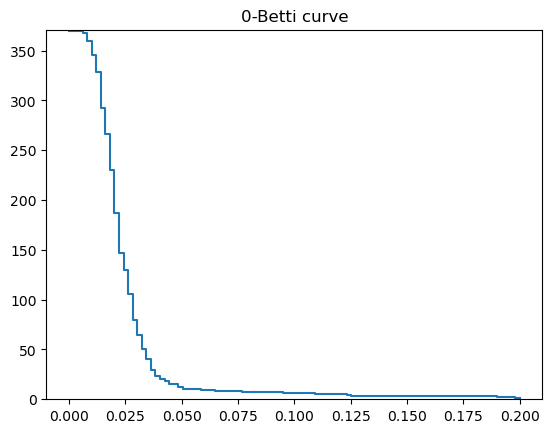

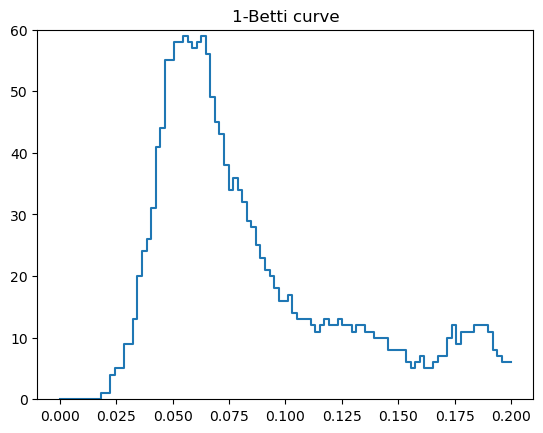

In [70]:
plt.figure()
plt.step(I, BettiOpen1[0])
plt.ylim(0, max(BettiOpen1[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, BettiOpen1[1])
plt.ylim(0, max(BettiOpen1[1])+1)
plt.title('1-Betti curve')
plt.show()

In [71]:
# Comparação das estruturas
print('Closed VS Closed:')
print(np.linalg.norm(BettiClosed1[1]-BettiClosed2[1]))

print('Open VS open:')
print(np.linalg.norm(BettiOpen1[1]-BettiOpen2[1]))


Closed VS Closed:
34.785054261852174
Open VS open:
40.50925820105819


In [72]:
# Comparação de diferentes estruturas

print('Closed VS open:')

print(np.linalg.norm(BettiClosed1[1]-BettiOpen1[1]))

print(np.linalg.norm(BettiClosed1[1]-BettiOpen2[1]))

print(np.linalg.norm(BettiClosed2[1]-BettiOpen1[1]))

print(np.linalg.norm(BettiClosed2[1]-BettiOpen2[1]))

Closed VS open:
38.06573262134856
23.53720459187964
38.61346915261564
28.705400188814647
